# FR Prediction and Modeling

In [9]:
# Import module
import csv
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from scipy.stats import boxcox
from google.colab import files

In [10]:
# Upload Original Files
!gdown --id '1U71V4dk90qU5hGeJvDjpuvQAuK0NSiCi'

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1U71V4dk90qU5hGeJvDjpuvQAuK0NSiCi
To: /content/20230317.xlsx
100% 37.2k/37.2k [00:00<00:00, 35.0MB/s]


In [11]:
path_Ori = './20230317.xlsx'
file_name = './20230317_FR.csv'

# delete big title and save to csv
def xlsx_to_csv_pd():
    data_xls = pd.read_excel(path_Ori, index_col=0, header=0)
    data_xls.to_csv(file_name, encoding='utf-8', header=None)

xlsx_to_csv_pd() # 2 csv

In [12]:
# Complete the title
with open(file_name) as f:
    data=[row for row in csv.reader(f)]

with open(file_name, 'w', encoding='utf-8') as f:
    w = csv.writer(f)
    data[0][0]="Model"
    for row in data:
        w.writerow(row)  

In [13]:
# Drop 0 in Valid-FR
import pandas as pd

file_name = './20230317_FR.csv'
data = pd.read_csv(file_name)
filtered_data = data[data['Valid-FR'] != 0]
filtered_data.to_csv(file_name, index=False)


In [14]:
data = pd.read_csv(file_name)
data.columns = data.columns.str.replace(' ', '') # delete space
data.to_csv(file_name, encoding='utf-8', index=None)
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Model         98 non-null     object 
 1   LPore         98 non-null     int64  
 2   MPore         98 non-null     int64  
 3   SPore         98 non-null     int64  
 4   CWST          98 non-null     int64  
 5   PoreSize      98 non-null     float64
 6   Flowrate(FR)  98 non-null     float64
 7   WBC(DR)       98 non-null     float64
 8   Valid-FR      98 non-null     int64  
 9   Valid-DR      98 non-null     int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 7.8+ KB
None
       LPore  MPore      SPore        CWST   PoreSize  Flowrate(FR)  \
count   98.0   98.0  98.000000   98.000000  98.000000     98.000000   
mean     1.0    3.0   9.744898   99.489796   4.179592      0.893869   
std      0.0    0.0   1.730927   12.630551   0.530731      0.376455   
min      1.0    3.0   6.000000

<ipython-input-15-99907803573b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = X.corr()


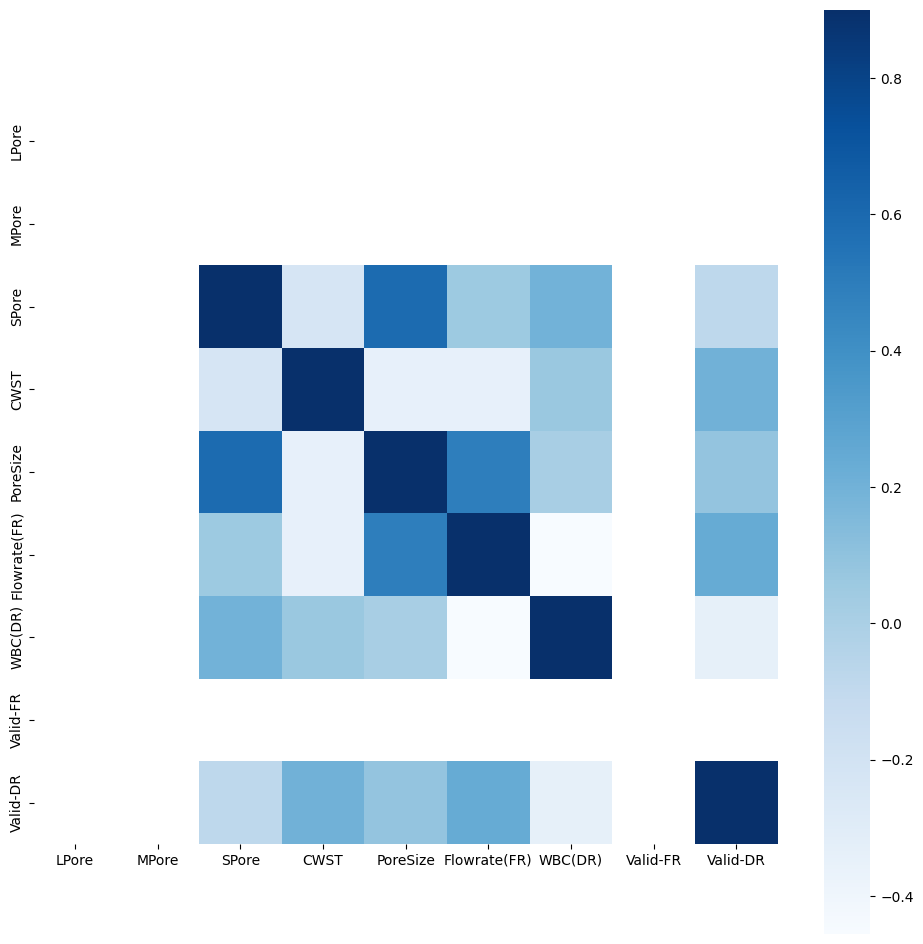

In [15]:
def draw_corr_picture(X):   # 相關係數圖
    corrmat = X.corr()
    plt.subplots(figsize=(12,12))
    sns.heatmap(corrmat,vmax=0.9,square=True,cmap='Blues')
    plt.show()

draw_corr_picture(data)

In [16]:
# Drop L/M Pore
data = pd.read_csv(file_name)
data = data.drop(['LPore', 'MPore'], axis=1)
data.to_csv(file_name, index=False)

In [17]:
import numpy as np

x = data[data.columns[1:4]]
y = np.ravel(data[["Flowrate(FR)"]]) # FR

x = (x - x.min()) / (x.max() - x.min())

bestfeatures = SelectKBest(score_func=f_regression, k=3)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Flowrate(FR)']  #name the data_frame columns
print(featureScores.nlargest(3, 'Flowrate(FR)'))

      Specs  Flowrate(FR)
2  PoreSize     30.751312
1      CWST     12.600964
0     SPore      0.273386


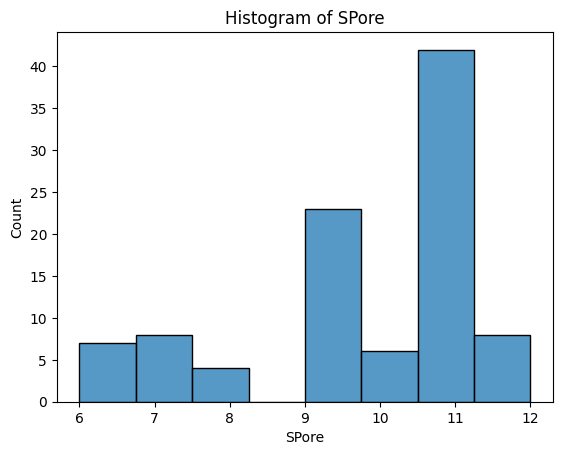

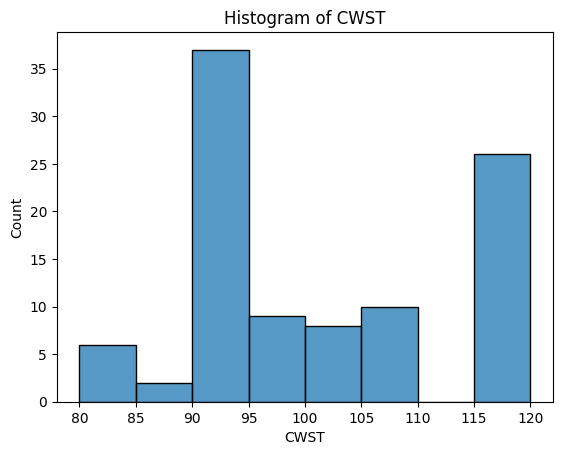

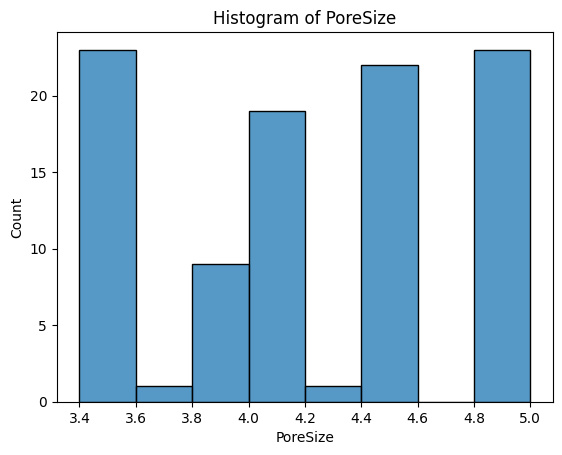

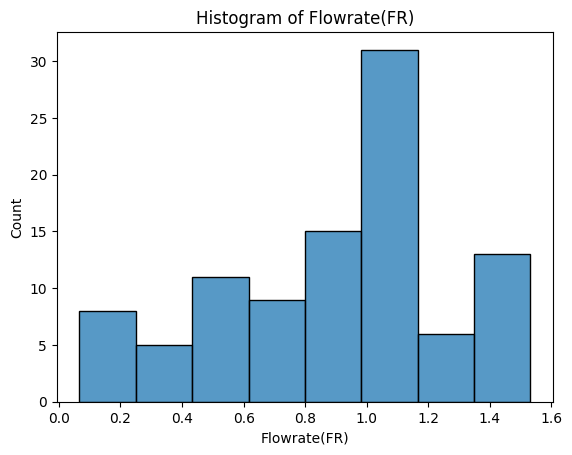

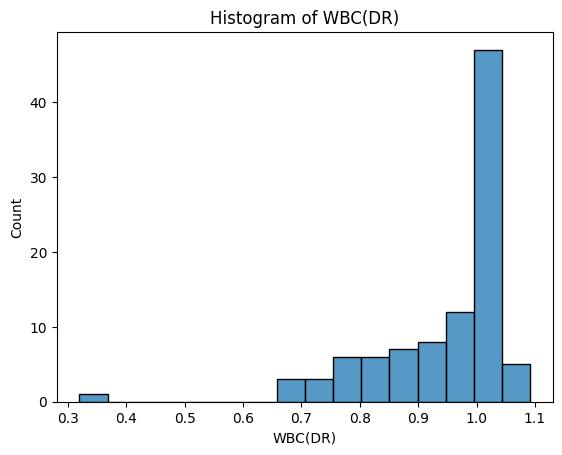

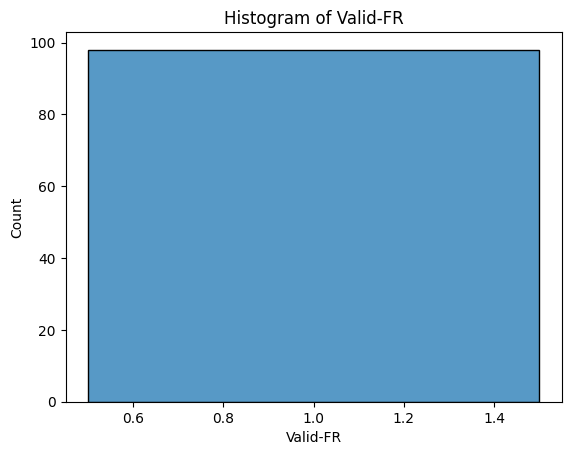

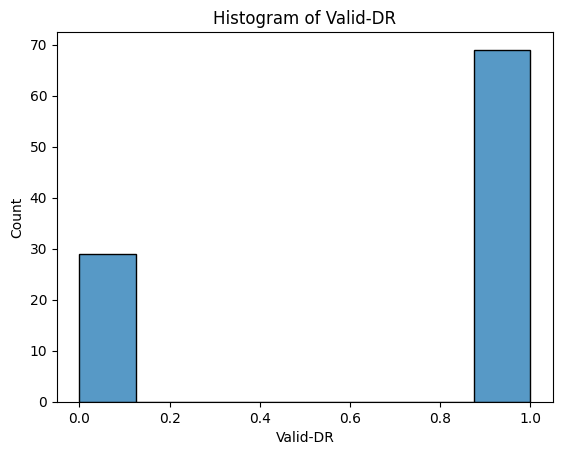

In [18]:
data = pd.read_csv(file_name)
features = data.drop(["Model"], axis=1)

for column in features.columns:
    plt.figure()
    sns.histplot(features[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.show()

In [13]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Doing ['SPore'] ...
Doing ['CWST'] ...
Doing ['PoreSize'] ...
Doing ['SPore', 'CWST'] ...
Doing ['SPore', 'PoreSize'] ...
Doing ['CWST', 'PoreSize'] ...
Doing ['SPore', 'CWST', 'PoreSize'] ...


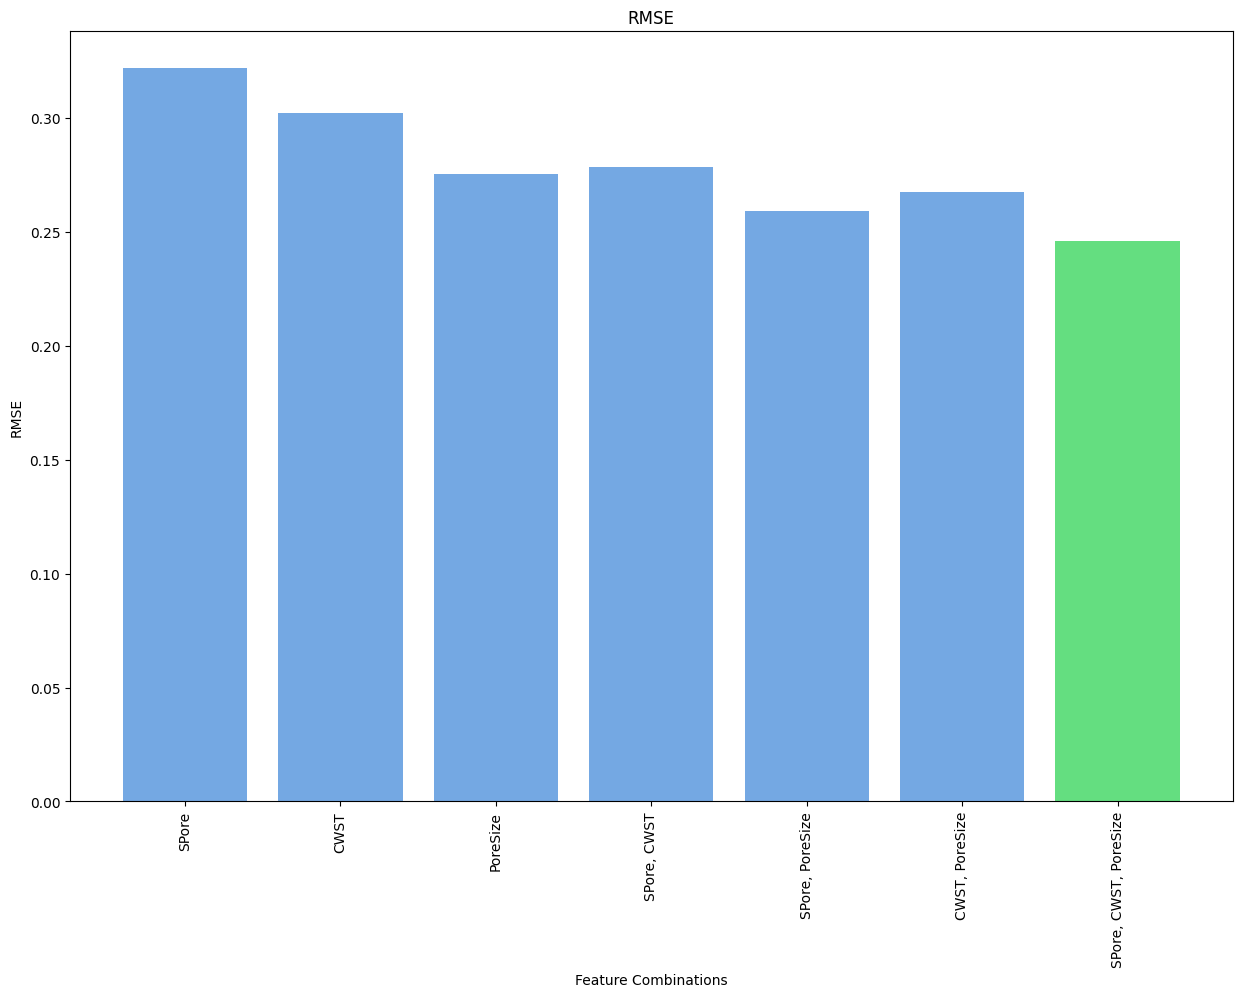

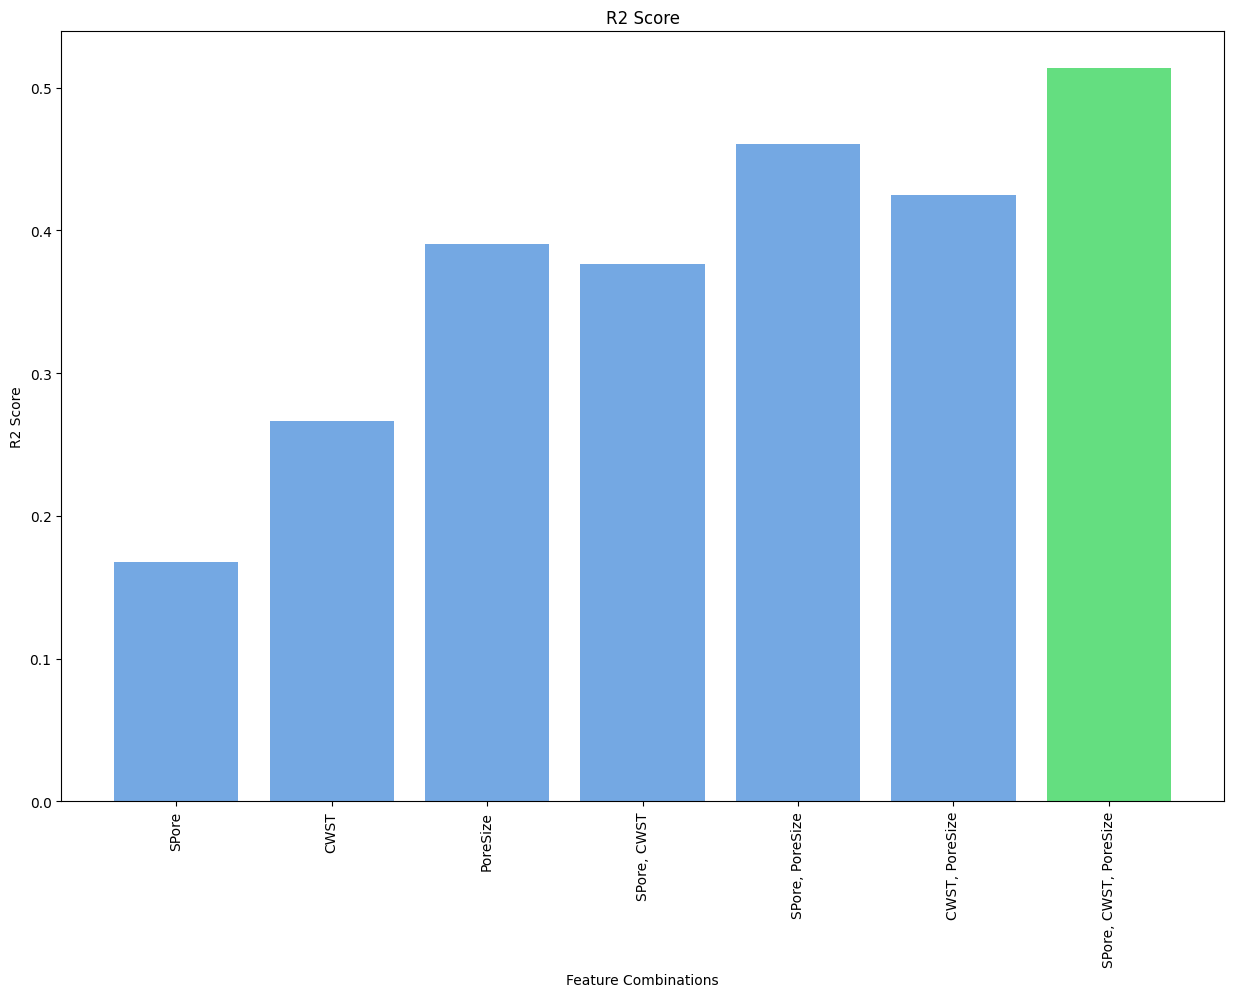

Best feature combination: ('SPore', 'CWST', 'PoreSize')
Best Root Mean squared error: 0.24609927972724321
Best R2 score: 0.5136324131712431


In [14]:
# !!!!!!! XGBoost !!!!!!!!

import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load CSV
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Pre-process
def preprocess_data(data):
    data = data.dropna()
    # Select features and target
    X = data.drop(["Model", "Flowrate(FR)","Valid-FR", "Valid-DR", "WBC(DR)"], axis=1)
    y = data["Flowrate(FR)"]
    return X, y

# Train
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBRegressor(objective="reg:squarederror", n_estimators=1000, early_stopping_rounds=500)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    return model, X_test, y_test

# Evaluate
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2


def brute_force_search(data):
    X, y = preprocess_data(data)
    feature_combinations = []
    for i in range(1, len(X.columns) + 1):
        feature_combinations.extend(list(itertools.combinations(X.columns, i)))
    
    best_rmse = float('inf')
    best_r2 = 0
    best_combination = None
    best_model = None
    best_X_test = None
    best_y_test = None

    rmse_values = []
    r2_values = []
    combination_labels = []

    for combination in feature_combinations:
        X_comb = X[list(combination)]
        print('Doing ' + str(X_comb.columns.tolist()) + ' ...')
        model, X_test, y_test = train_model(X_comb, y)
        rmse, r2 = evaluate_model(model, X_test, y_test)
        rmse_values.append(rmse)
        r2_values.append(r2)
        combination_labels.append(', '.join(combination))

        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_combination = combination
            best_model = model
            best_X_test = X_test
            best_y_test = y_test
    
    visualize_results(combination_labels, rmse_values, r2_values)

    return best_combination, best_model, best_X_test, best_y_test

def visualize_results(combination_labels, rmse_values, r2_values):
    # Identify the best RMSE and R2
    best_rmse_index = rmse_values.index(min(rmse_values))
    best_r2_index = r2_values.index(max(r2_values))

    # Set colors for the bars
    rmse_colors = ['#74a8e3'] * len(rmse_values)
    rmse_colors[best_rmse_index] = '#64de80'
    r2_colors = ['#74a8e3'] * len(r2_values)
    r2_colors[best_r2_index] = '#64de80'

    # Plot RMSE values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, rmse_values, color=rmse_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.title('RMSE')
    plt.show()

    # Plot R2 values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, r2_values, color=r2_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('R2 Score')
    plt.xticks(rotation=90)
    plt.title('R2 Score')
    plt.show()

def main():
    file_path = file_name
    data = load_data(file_path)
    best_combination, best_model, best_X_test, best_y_test = brute_force_search(data)
    best_rmse, best_r2 = evaluate_model(best_model, best_X_test, best_y_test)
    
    print(f"Best feature combination: {best_combination}")
    print(f"Best Root Mean squared error: {best_rmse}")
    print(f"Best R2 score: {best_r2}")

if __name__ == "__main__":
    main()

Feature combinations:   0%|          | 0/7 [00:00<?, ?it/s]

Doing ['SPore'] ...



Feature combinations:  14%|█▍        | 1/7 [00:17<01:45, 17.56s/it]

Doing ['CWST'] ...



Feature combinations:  29%|██▊       | 2/7 [00:45<01:58, 23.73s/it]

Doing ['PoreSize'] ...



Feature combinations:  43%|████▎     | 3/7 [00:55<01:10, 17.63s/it]

Doing ['SPore', 'CWST'] ...



Feature combinations:  57%|█████▋    | 4/7 [01:06<00:44, 14.99s/it]

Doing ['SPore', 'PoreSize'] ...



Feature combinations:  71%|███████▏  | 5/7 [01:18<00:27, 13.59s/it]

Doing ['CWST', 'PoreSize'] ...



Feature combinations:  86%|████████▌ | 6/7 [01:29<00:12, 12.81s/it]

Doing ['SPore', 'CWST', 'PoreSize'] ...



Feature combinations: 100%|██████████| 7/7 [01:41<00:00, 14.56s/it]


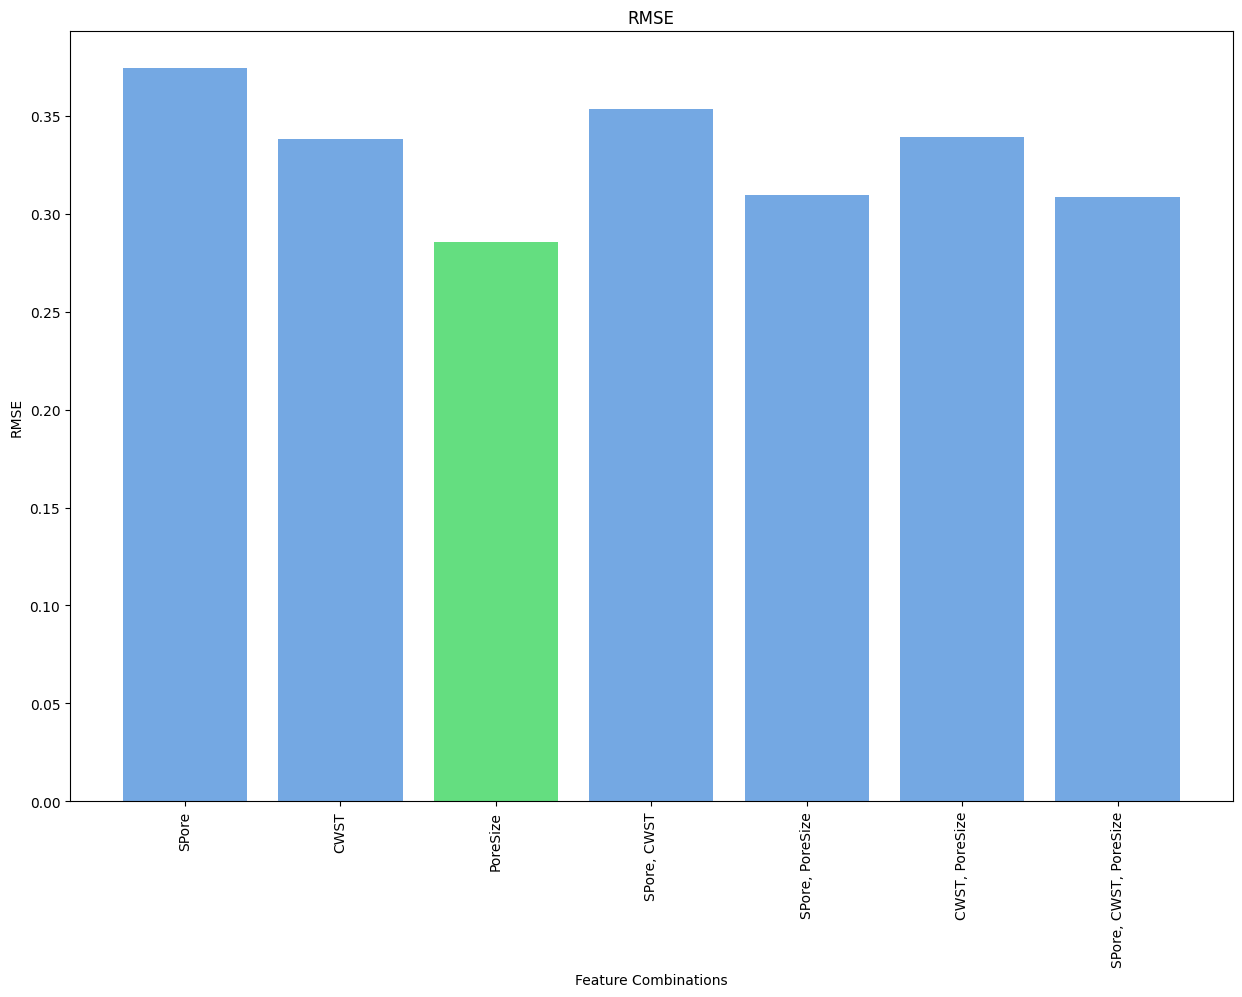

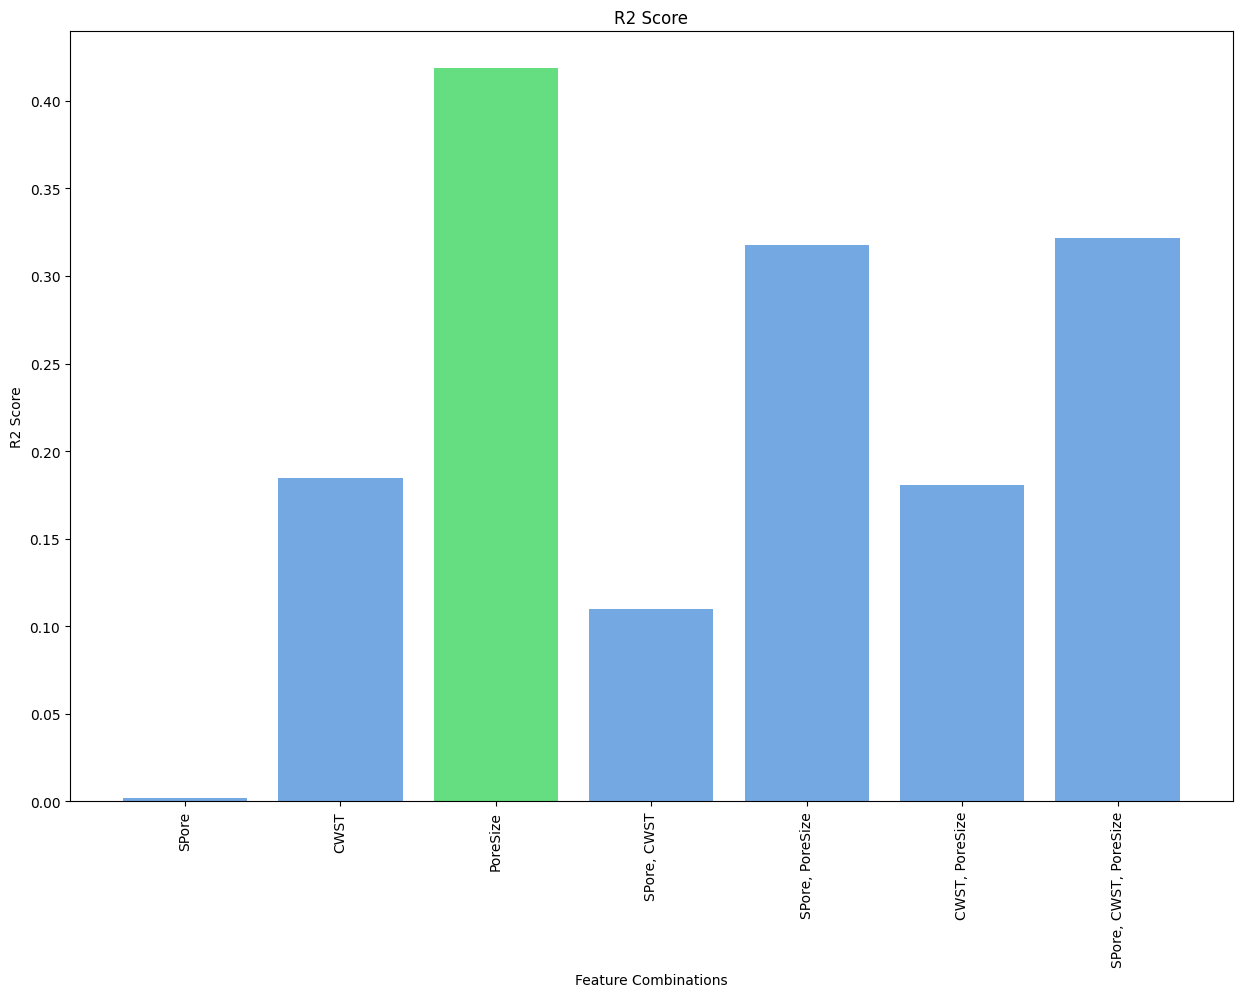

Best feature combination: ('PoreSize',)
Best Root Mean squared error: 0.285555630196481
Best R2 score: 0.4186881885195929


In [15]:
# XGBoost Leave One Out

import pandas as pd
import itertools
import numpy as np
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

# Load CSV
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Pre-process
def preprocess_data(data):
    data = data.dropna()
    # Select features and target
    X = data.drop(["Model", "Flowrate(FR)","Valid-FR", "Valid-DR", "WBC(DR)"], axis=1)
    y = data["Flowrate(FR)"]
    return X, y

# Train
def train_model(X, y):
    loo = LeaveOneOut()
    models = []
    y_tests = []
    y_preds = []

    for train_index, test_index in tqdm(loo.split(X), total=len(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = XGBRegressor(objective="reg:squarederror", n_estimators=500)
        model.fit(X_train, y_train, verbose=False)
        models.append(model)

        y_pred = model.predict(X_test)
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    return models, np.array(y_tests), np.array(y_preds)

# Evaluate
def evaluate_model(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

def brute_force_search(data):
    X, y = preprocess_data(data)
    feature_combinations = []
    for i in range(1, len(X.columns) + 1):
        feature_combinations.extend(list(itertools.combinations(X.columns, i)))
    
    best_rmse = float('inf')
    best_r2 = 0
    best_combination = None
    best_models = None
    best_y_tests = None
    best_y_preds = None

    rmse_values = []
    r2_values = []
    combination_labels = []

    for combination in tqdm(feature_combinations, desc="Feature combinations"):
        X_comb = X[list(combination)]
        print('Doing ' + str(X_comb.columns.tolist()) + ' ...')
        models, y_tests, y_preds = train_model(X_comb, y)
        rmse, r2 = evaluate_model(y_tests, y_preds)
        rmse_values.append(rmse)
        r2_values.append(r2)
        combination_labels.append(', '.join(combination))

        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_combination = combination
            best_models = models
            best_y_tests = y_tests
            best_y_preds = y_preds

    visualize_results(combination_labels, rmse_values, r2_values)

    return best_combination, best_models, best_y_tests, best_y_preds

def visualize_results(combination_labels, rmse_values, r2_values):
    # Identify the best RMSE and R2
    best_rmse_index = rmse_values.index(min(rmse_values))
    best_r2_index = r2_values.index(max(r2_values))

    # Set colors for the bars
    rmse_colors = ['#74a8e3'] * len(rmse_values)
    rmse_colors[best_rmse_index] = '#64de80'
    r2_colors = ['#74a8e3'] * len(r2_values)
    r2_colors[best_r2_index] = '#64de80'

    # Plot RMSE values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, rmse_values, color=rmse_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.title('RMSE')
    plt.show()

    # Plot R2 values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, r2_values, color=r2_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('R2 Score')
    plt.xticks(rotation=90)
    plt.title('R2 Score')
    plt.show()

def main():
    file_path = file_name
    data = load_data(file_path)
    best_combination, best_models, best_y_tests, best_y_preds = brute_force_search(data)
    best_rmse, best_r2 = evaluate_model(best_y_tests, best_y_preds)
    
    print(f"Best feature combination: {best_combination}")
    print(f"Best Root Mean squared error: {best_rmse}")
    print(f"Best R2 score: {best_r2}")

if __name__ == "__main__":
    main()


Feature combinations:   0%|          | 0/7 [00:00<?, ?it/s]

Doing ['SPore'] ...



Feature combinations:  14%|█▍        | 1/7 [00:02<00:16,  2.83s/it]

Doing ['CWST'] ...



Feature combinations:  29%|██▊       | 2/7 [00:09<00:26,  5.24s/it]

Doing ['PoreSize'] ...



Feature combinations:  43%|████▎     | 3/7 [00:16<00:23,  5.77s/it]

Doing ['SPore', 'CWST'] ...



Feature combinations:  57%|█████▋    | 4/7 [00:38<00:36, 12.22s/it]

Doing ['SPore', 'PoreSize'] ...



Feature combinations:  71%|███████▏  | 5/7 [00:59<00:31, 15.60s/it]

Doing ['CWST', 'PoreSize'] ...



Feature combinations:  86%|████████▌ | 6/7 [01:19<00:16, 16.93s/it]

Doing ['SPore', 'CWST', 'PoreSize'] ...



Feature combinations: 100%|██████████| 7/7 [01:49<00:00, 15.61s/it]


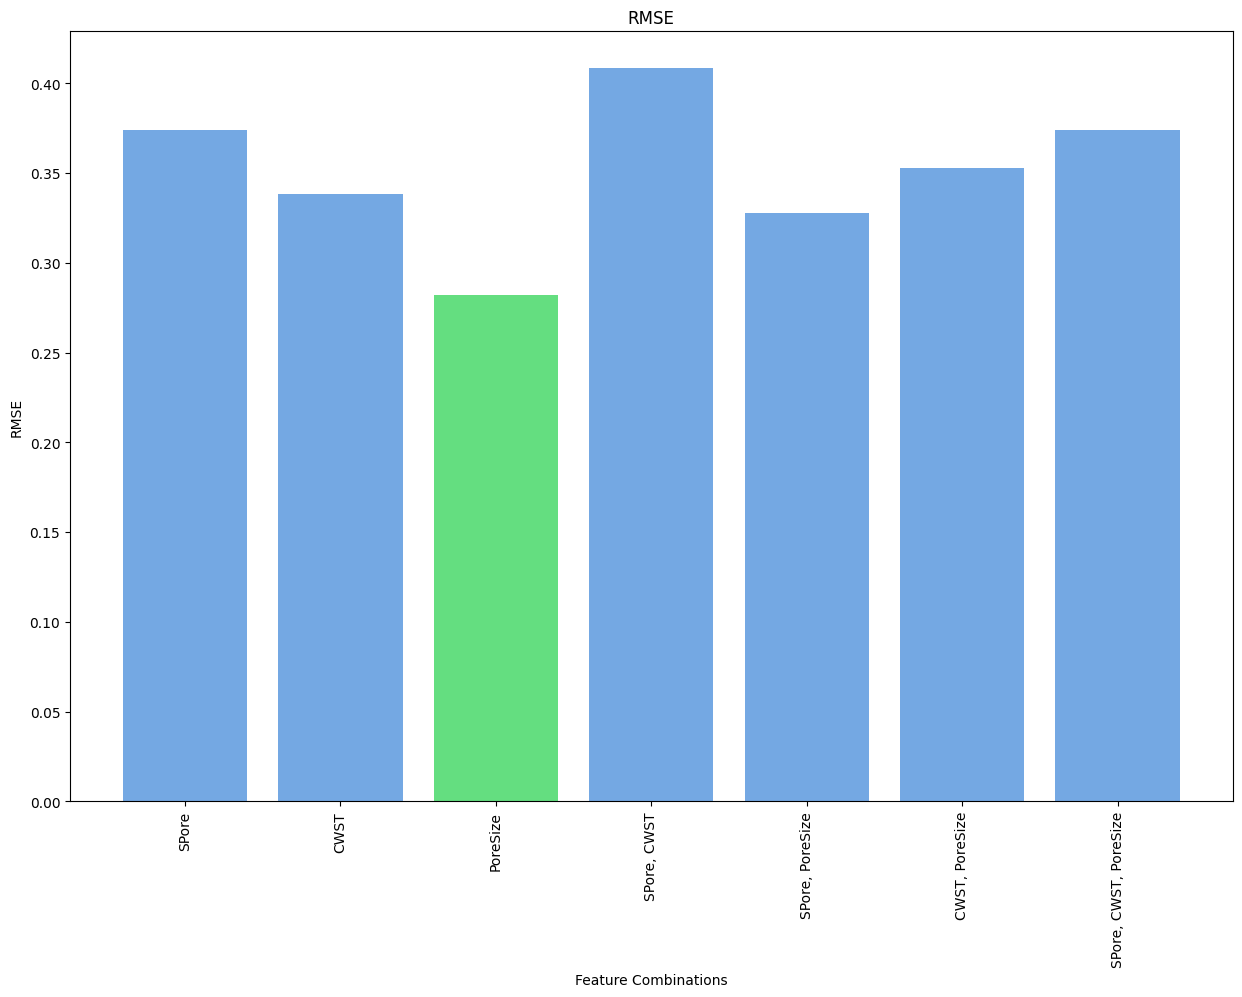

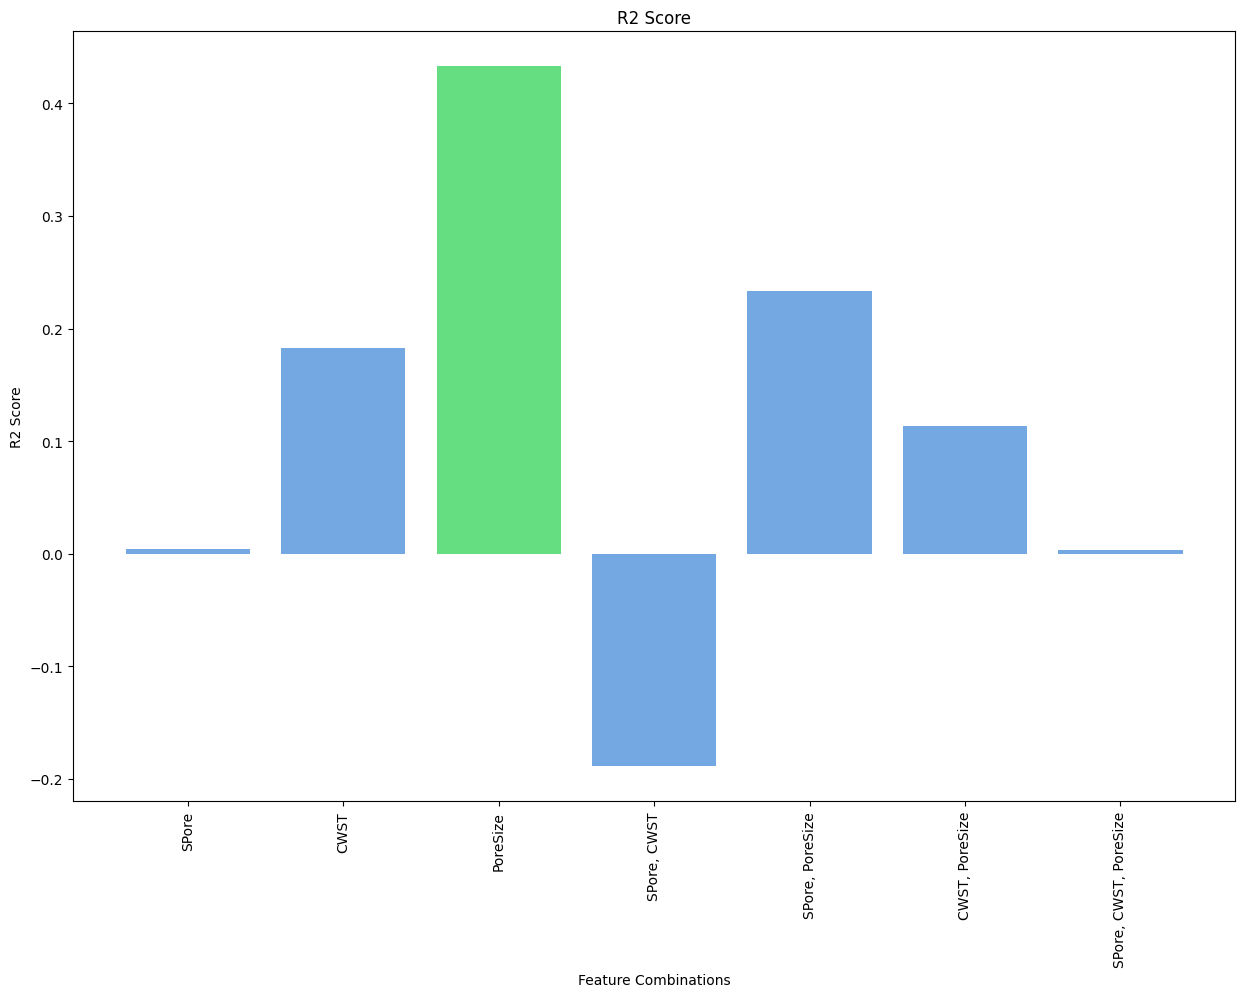

Best feature combination: ('PoreSize',)
Best Root Mean squared error: 0.2820473969571314
Best R2 score: 0.4328840206326887


In [16]:
# MLPRegressor Leave One Out

import pandas as pd
import itertools
import numpy as np
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# Load CSV
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def preprocess_data(data):
    data = data.dropna()
    # Select features and target
    X = data.drop(["Model", "Flowrate(FR)","Valid-FR", "Valid-DR", "WBC(DR)"], axis=1)
    y = data["Flowrate(FR)"]
    
    # Save column
    column_names = X.columns
    
    # Scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert scaled data back to DataFrame
    X = pd.DataFrame(X, columns=column_names)

    return X, y, column_names


# Train
def train_model(X, y):
    loo = LeaveOneOut()
    models = []
    y_tests = []
    y_preds = []

    for train_index, test_index in tqdm(loo.split(X), total=len(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = MLPRegressor(hidden_layer_sizes=(10,10),activation="relu", solver='lbfgs', max_iter=10000, random_state=42)
        model.fit(X_train, y_train)
        models.append(model)

        y_pred = model.predict(X_test)
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    return models, np.array(y_tests), np.array(y_preds)

# Evaluate
def evaluate_model(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

def brute_force_search(data):
    X, y, column_names = preprocess_data(data)
    feature_combinations = []
    for i in range(1, len(column_names) + 1):
        feature_combinations.extend(list(itertools.combinations(column_names, i)))
    
    best_rmse = float('inf')
    best_r2 = 0
    best_combination = None
    best_models = None
    best_y_tests = None
    best_y_preds = None

    rmse_values = []
    r2_values = []
    combination_labels = []

    for combination in tqdm(feature_combinations, desc="Feature combinations"):
        X_comb = X[list(combination)]
        print('Doing ' + str(X_comb.columns.tolist()) + ' ...')
        models, y_tests, y_preds = train_model(X_comb, y)
        rmse, r2 = evaluate_model(y_tests, y_preds)
        rmse_values.append(rmse)
        r2_values.append(r2)
        combination_labels.append(', '.join(combination))

        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_combination = combination
            best_models = models
            best_y_tests = y_tests
            best_y_preds = y_preds

    visualize_results(combination_labels, rmse_values, r2_values)

    return best_combination, best_models, best_y_tests, best_y_preds

def visualize_results(combination_labels, rmse_values, r2_values):
    # Identify the best RMSE and R2
    best_rmse_index = rmse_values.index(min(rmse_values))
    best_r2_index = r2_values.index(max(r2_values))

    # Set colors for the bars
    rmse_colors = ['#74a8e3'] * len(rmse_values)
    rmse_colors[best_rmse_index] = '#64de80'
    r2_colors = ['#74a8e3'] * len(r2_values)
    r2_colors[best_r2_index] = '#64de80'

    # Plot RMSE values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, rmse_values, color=rmse_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.title('RMSE')
    plt.show()

    # Plot R2 values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, r2_values, color=r2_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('R2 Score')
    plt.xticks(rotation=90)
    plt.title('R2 Score')
    plt.show()

def main():
    file_path = file_name
    data = load_data(file_path)
    best_combination, best_models, best_y_tests, best_y_preds = brute_force_search(data)
    best_rmse, best_r2 = evaluate_model(best_y_tests, best_y_preds)
    
    print(f"Best feature combination: {best_combination}")
    print(f"Best Root Mean squared error: {best_rmse}")
    print(f"Best R2 score: {best_r2}")

if __name__ == "__main__":
    main()


In [2]:
# MLP Leave One Out and Plot

import pandas as pd
import itertools
import numpy as np
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
# Load CSV
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def preprocess_data(data):
    data = data.dropna()
    
    # Select features and target
    X = data.drop(["Flowrate(FR)", "Model"], axis=1) 
    y = data["Flowrate(FR)"]
    
    # Save column names
    column_names = X.columns
    
    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1.5, 1.5))
    X = scaler.fit_transform(X)

    # Convert scaled data back to DataFrame
    X = pd.DataFrame(X, columns=column_names)

    # Convert columns to string type
    X.columns = X.columns.astype(str)

    return X, y, column_names, scaler


# Train
def train_model(X, y):
    loo = LeaveOneOut()
    models = []
    y_tests = []
    y_preds = []

    for train_index, test_index in tqdm(loo.split(X), total=len(X)):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
  
        model = MLPRegressor(hidden_layer_sizes=(5,5),activation="relu", solver='lbfgs', max_iter=10000, random_state=42)
        model.fit(X_train, y_train)
        models.append(model)

        y_pred = model.predict(X_test)
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    return models, np.array(y_tests), np.array(y_preds)

# Evaluate
def evaluate_model(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

def brute_force_search(data):
    X, y, column_names = preprocess_data(data)
    feature_combinations = []
    for i in range(1, len(column_names) + 1):
        feature_combinations.extend(list(itertools.combinations(column_names, i)))
    
    best_rmse = float('inf')
    best_r2 = 0
    best_combination = None
    best_models = None
    best_y_tests = None
    best_y_preds = None

    rmse_values = []
    r2_values = []
    combination_labels = []

    for combination in tqdm(feature_combinations, desc="Feature combinations"):
        X_comb = X[list(combination)]
        print('Doing ' + str(X_comb.columns.tolist()) + ' ...')
        models, y_tests, y_preds = train_model(X_comb, y)
        rmse, r2 = evaluate_model(y_tests, y_preds)
        rmse_values.append(rmse)
        r2_values.append(r2)
        combination_labels.append(', '.join(combination))

        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_combination = combination
            best_models = models
            best_y_tests = y_tests
            best_y_preds = y_preds

    visualize_results(combination_labels, rmse_values, r2_values)

    return best_combination, best_models, best_y_tests, best_y_preds


def visualize_surface(X, y, models, data, scaler):
    # Extract values for Model column
    model_names = data['Model']

    # Calculate the average prediction for each point in the grid
    xx, yy = np.meshgrid(
        np.linspace(X['PoreSize'].min(), X['PoreSize'].max(), 100),
        np.linspace(X['SPore'].min(), X['SPore'].max(), 100)
    )

    Z = np.zeros(xx.shape)
    for model in models:
        Z += model.predict(np.c_[yy.ravel(), xx.ravel()]).reshape(xx.shape)
    Z /= len(models)

    # Create a surface color matrix based on Z values
    surface_color = np.where(Z > 0.8, 1, 0)

    # Define custom colorscale
    custom_colorscale = [[0, 'rgb(30,144,255)'], [1, 'red']]

    # Create a 3D surface plot
    fig = go.Figure(
        go.Surface(x=xx, y=yy, z=Z, colorscale=custom_colorscale, surfacecolor=surface_color)
    )

    # Add scatter points with labels
    fig.add_trace(
        go.Scatter3d(
            x=X['SPore'], y=X['PoreSize'], z=y,
            mode='markers+text',
            text=model_names,
            textposition='top center',
            marker=dict(size=3, color='red')
        )
    )

    # Set layout
    fig.update_layout(
        title='3D Surface Plot',
        scene=dict(
            xaxis=dict(title='SPore',tickmode='array',tickvals=[-2.174645, -1.5939495,-1.0132540,-0.4325585,0.1481370,0.7288325, 1.309528], ticktext=[6,7,8,9,10,11,12]),
            yaxis=dict(title='PoreSize',tickmode='array',tickvals=[-1.476455,-1.043567,-0.6106804,-0.177793,0.255094,0.687981,1.120868, 1.553755],ticktext=[3.4,3.6,3.8,4.0,4.2,4.4,4.8,5.0]),
            zaxis=dict(title='Flowrate(FR)'),
            aspectmode='manual',
            aspectratio=dict(x=2, y=2, z=2)
        )
    )


    # Show the figure
    fig.show()

def main():
    file_path = '20230317_FR.csv'
    data = load_data(file_path)

    data = data[['PoreSize', 'SPore', 'Flowrate(FR)', 'Model']]

    X, y, column_names , scaler= preprocess_data(data)
    best_models, y_tests, y_preds = train_model(X, y)
    best_rmse, best_r2 = evaluate_model(y_tests, y_preds)

    import warnings
    warnings.filterwarnings("ignore")

    visualize_surface(X, y, best_models, data, scaler)

if __name__ == "__main__":
    main()


100%|██████████| 98/98 [00:11<00:00,  8.21it/s]


# DR prediction and Modeling

In [29]:
path_Ori = './20230317.xlsx'
file_name = './20230317_DR.csv'

# delete big title and save to csv
def xlsx_to_csv_pd():
    data_xls = pd.read_excel(path_Ori, index_col=0, header=0)
    data_xls.to_csv(file_name, encoding='utf-8', header=None)

xlsx_to_csv_pd() # 2 csv

In [30]:
# Complete the title
with open(file_name) as f:
    data=[row for row in csv.reader(f)]

with open(file_name, 'w', encoding='utf-8') as f:
    w = csv.writer(f)
    data[0][0]="Model"
    for row in data:
        w.writerow(row)  

In [31]:
# Drop 0 in Valid-DR
import pandas as pd

file_name = './20230317_DR.csv'
data = pd.read_csv(file_name)
filtered_data = data[data['Valid-DR'] != 0]
filtered_data.to_csv(file_name, index=False)

In [32]:
data = pd.read_csv(file_name)
data.columns = data.columns.str.replace(' ', '') # delete space
data.to_csv(file_name, encoding='utf-8', index=None)
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Model         71 non-null     object 
 1   LPore         71 non-null     int64  
 2   MPore         71 non-null     int64  
 3   SPore         71 non-null     int64  
 4   CWST          71 non-null     int64  
 5   PoreSize      71 non-null     float64
 6   Flowrate(FR)  71 non-null     float64
 7   WBC(DR)       71 non-null     float64
 8   Valid-FR      71 non-null     int64  
 9   Valid-DR      71 non-null     int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 5.7+ KB
None
       LPore  MPore      SPore        CWST   PoreSize  Flowrate(FR)  \
count   71.0   71.0  71.000000   71.000000  71.000000     71.000000   
mean     1.0    3.0   9.549296  100.915493   4.218310      0.995142   
std      0.0    0.0   1.818859   13.019487   0.511946      0.450418   
min      1.0    3.0   6.000000

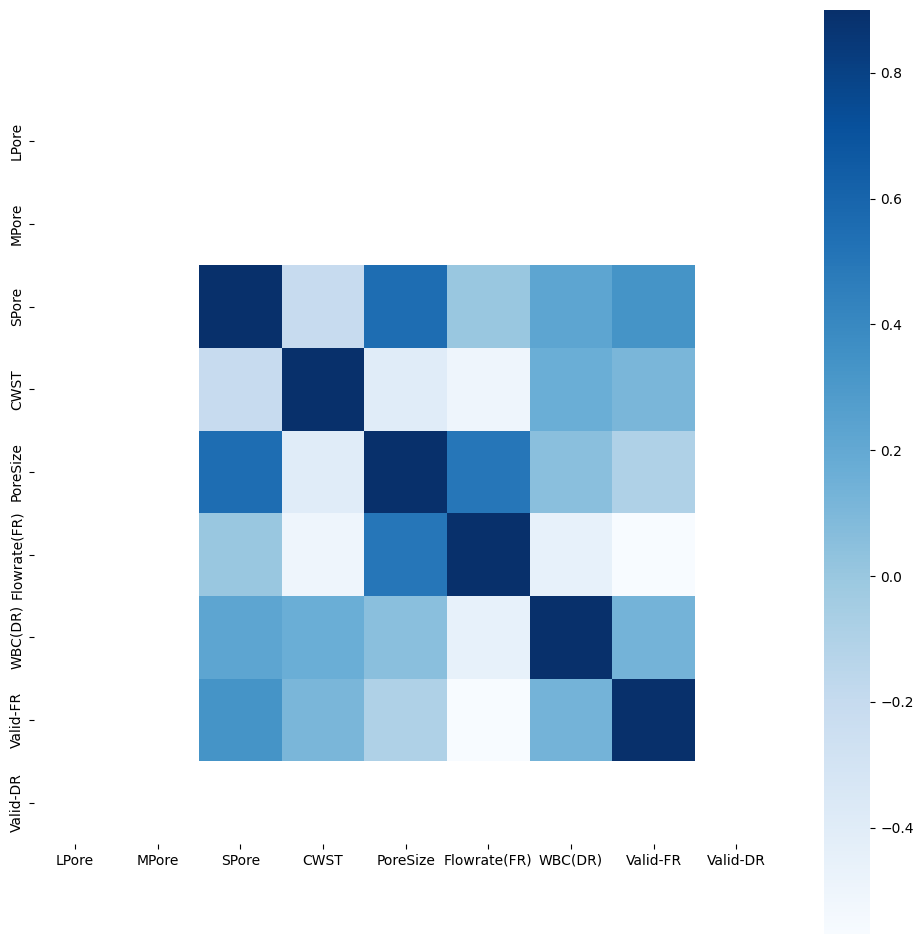

In [33]:
def draw_corr_picture(X):   # 相關係數圖
    corrmat = X.corr()
    plt.subplots(figsize=(12,12))
    sns.heatmap(corrmat,vmax=0.9,square=True,cmap='Blues')
    plt.show()

draw_corr_picture(data)

In [34]:
# Drop L/M Pore
data = pd.read_csv(file_name)
data = data.drop(['LPore', 'MPore'], axis=1)
data.to_csv(file_name, index=False)

In [35]:
import numpy as np

x = data[data.columns[1:4]]
y = np.ravel(data[["WBC(DR)"]]) # FR

x = (x - x.min()) / (x.max() - x.min())

bestfeatures = SelectKBest(score_func=f_regression, k=3)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'WBC(DR)']  #name the data_frame columns
print(featureScores.nlargest(3, 'WBC(DR)'))

      Specs   WBC(DR)
0     SPore  3.611812
1      CWST  2.044878
2  PoreSize  0.207273


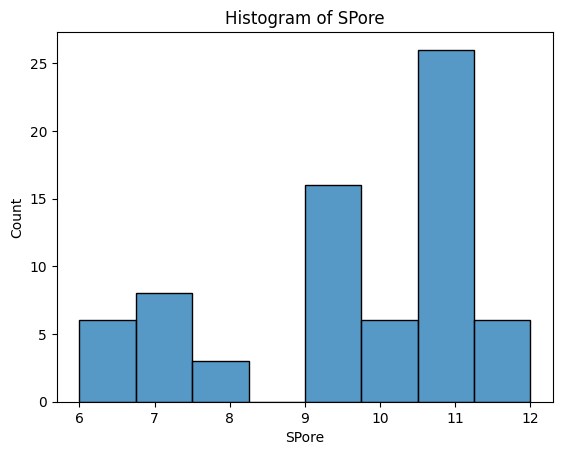

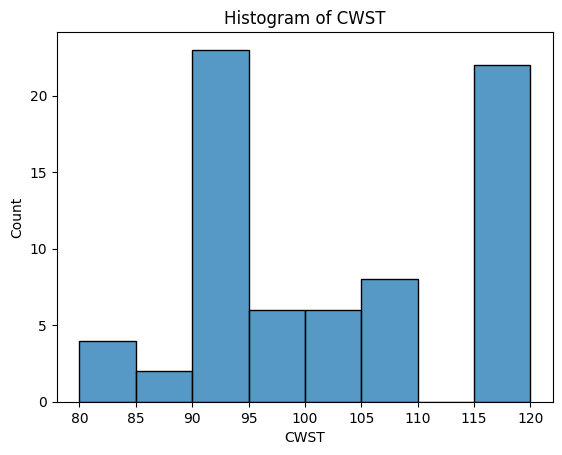

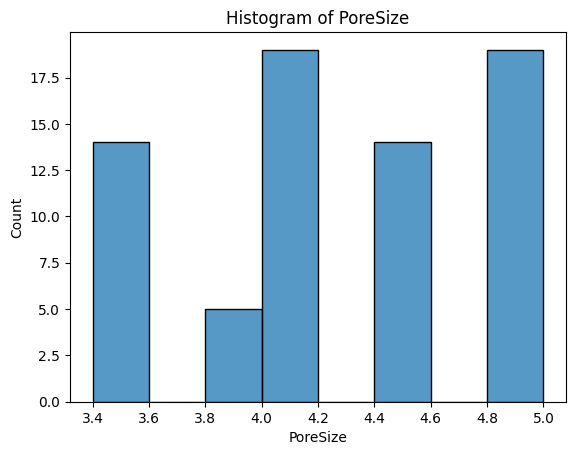

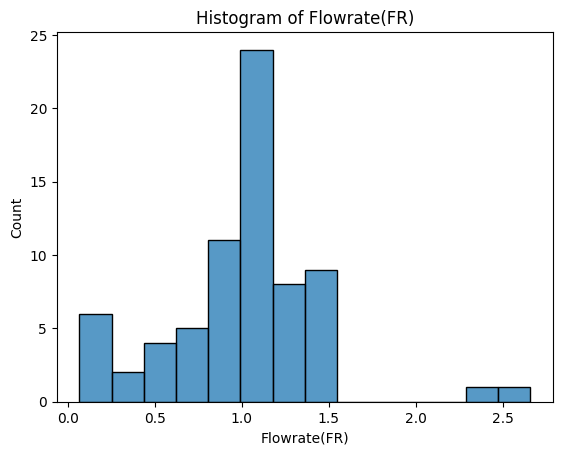

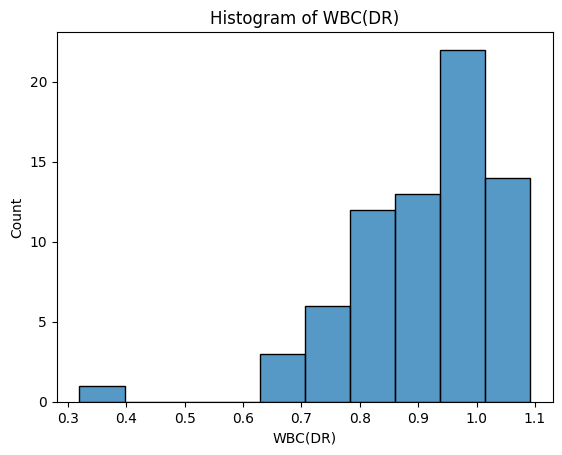

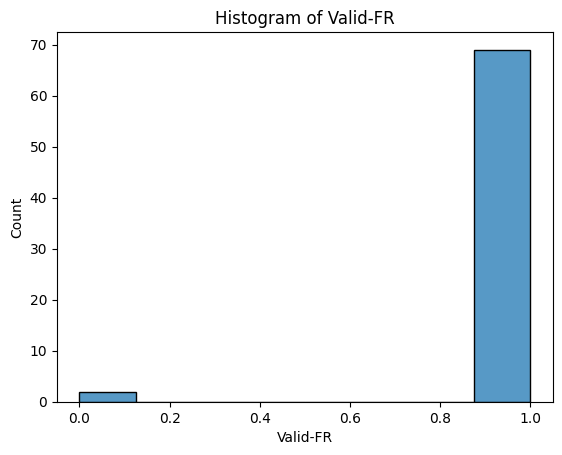

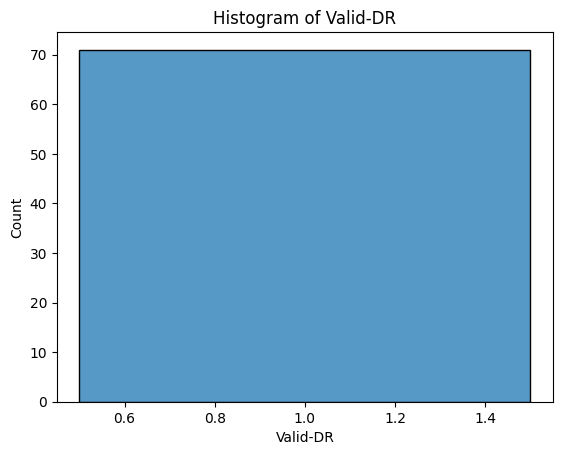

In [36]:
data = pd.read_csv(file_name)
features = data.drop(["Model"], axis=1)

for column in features.columns:
    plt.figure()
    sns.histplot(features[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.show()

Feature combinations:   0%|          | 0/7 [00:00<?, ?it/s]

Doing ['SPore'] ...



Feature combinations:  14%|█▍        | 1/7 [00:07<00:43,  7.18s/it]

Doing ['CWST'] ...



Feature combinations:  29%|██▊       | 2/7 [00:26<01:12, 14.44s/it]

Doing ['PoreSize'] ...



Feature combinations:  43%|████▎     | 3/7 [00:32<00:42, 10.66s/it]

Doing ['SPore', 'CWST'] ...



Feature combinations:  57%|█████▋    | 4/7 [00:41<00:29,  9.76s/it]

Doing ['SPore', 'PoreSize'] ...



Feature combinations:  71%|███████▏  | 5/7 [00:49<00:18,  9.27s/it]

Doing ['CWST', 'PoreSize'] ...



Feature combinations:  86%|████████▌ | 6/7 [00:56<00:08,  8.34s/it]

Doing ['SPore', 'CWST', 'PoreSize'] ...



Feature combinations: 100%|██████████| 7/7 [01:04<00:00,  9.26s/it]


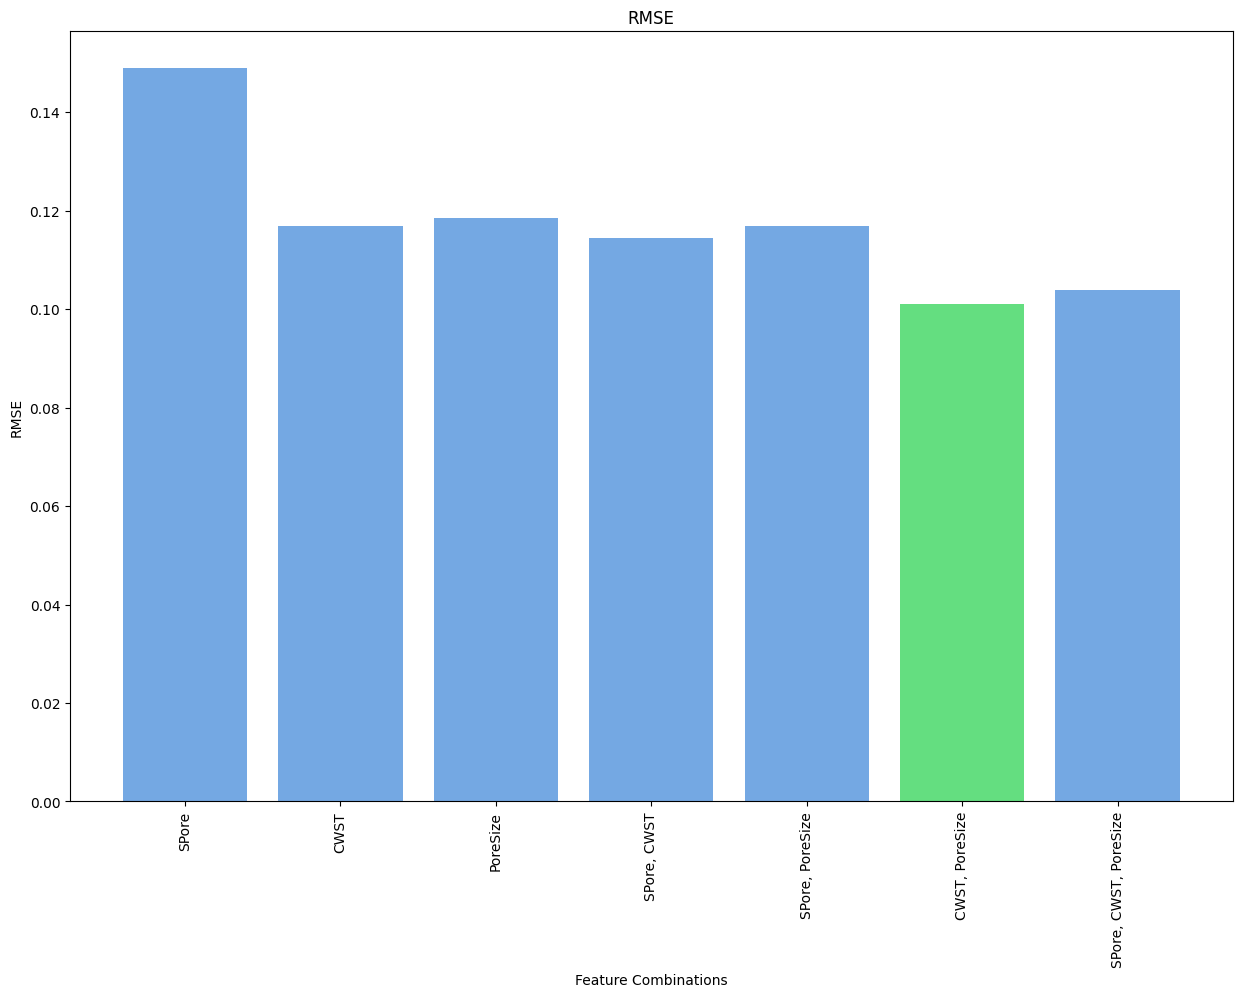

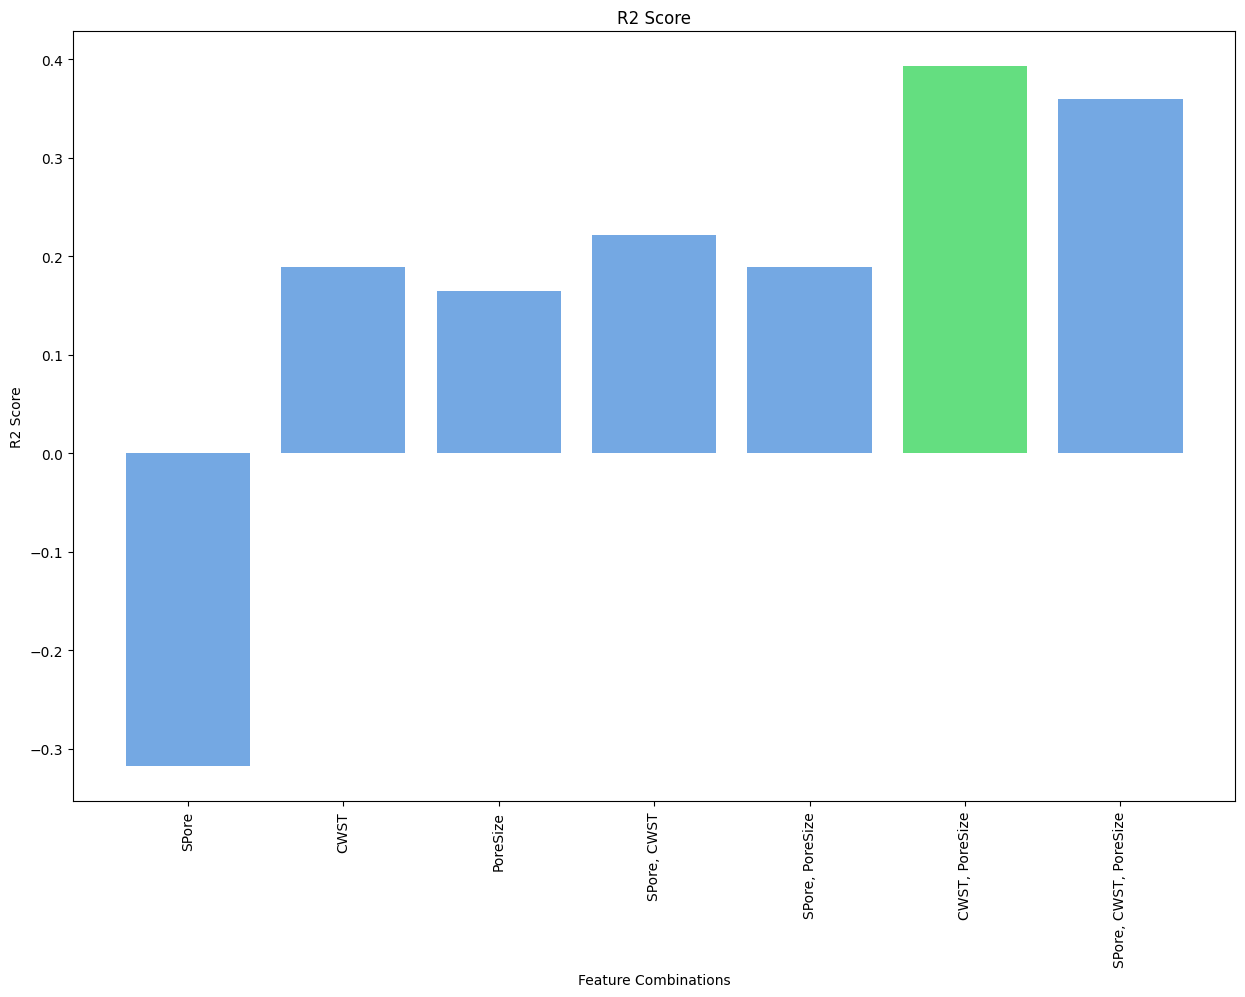

Best feature combination: ('CWST', 'PoreSize')
Best Root Mean squared error: 0.10109692551375597
Best R2 score: 0.39271011841320347


In [28]:
# XGBoost Leave One Out

import pandas as pd
import itertools
import numpy as np
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

# Load CSV
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Pre-process
def preprocess_data(data):
    data = data.dropna()
    # Select features and target
    X = data.drop(["Model", "Flowrate(FR)","Valid-FR", "Valid-DR", "WBC(DR)"], axis=1)
    y = data["WBC(DR)"]
    return X, y

# Train
def train_model(X, y):
    loo = LeaveOneOut()
    models = []
    y_tests = []
    y_preds = []

    for train_index, test_index in tqdm(loo.split(X), total=len(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = XGBRegressor(objective="reg:squarederror", n_estimators=500)
        model.fit(X_train, y_train, verbose=False)
        models.append(model)

        y_pred = model.predict(X_test)
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    return models, np.array(y_tests), np.array(y_preds)

# Evaluate
def evaluate_model(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

def brute_force_search(data):
    X, y = preprocess_data(data)
    feature_combinations = []
    for i in range(1, len(X.columns) + 1):
        feature_combinations.extend(list(itertools.combinations(X.columns, i)))
    
    best_rmse = float('inf')
    best_r2 = 0
    best_combination = None
    best_models = None
    best_y_tests = None
    best_y_preds = None

    rmse_values = []
    r2_values = []
    combination_labels = []

    for combination in tqdm(feature_combinations, desc="Feature combinations"):
        X_comb = X[list(combination)]
        print('Doing ' + str(X_comb.columns.tolist()) + ' ...')
        models, y_tests, y_preds = train_model(X_comb, y)
        rmse, r2 = evaluate_model(y_tests, y_preds)
        rmse_values.append(rmse)
        r2_values.append(r2)
        combination_labels.append(', '.join(combination))

        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_combination = combination
            best_models = models
            best_y_tests = y_tests
            best_y_preds = y_preds

    visualize_results(combination_labels, rmse_values, r2_values)

    return best_combination, best_models, best_y_tests, best_y_preds

def visualize_results(combination_labels, rmse_values, r2_values):
    # Identify the best RMSE and R2
    best_rmse_index = rmse_values.index(min(rmse_values))
    best_r2_index = r2_values.index(max(r2_values))

    # Set colors for the bars
    rmse_colors = ['#74a8e3'] * len(rmse_values)
    rmse_colors[best_rmse_index] = '#64de80'
    r2_colors = ['#74a8e3'] * len(r2_values)
    r2_colors[best_r2_index] = '#64de80'

    # Plot RMSE values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, rmse_values, color=rmse_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.title('RMSE')
    plt.show()

    # Plot R2 values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, r2_values, color=r2_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('R2 Score')
    plt.xticks(rotation=90)
    plt.title('R2 Score')
    plt.show()

def main():
    file_path = file_name
    data = load_data(file_path)
    best_combination, best_models, best_y_tests, best_y_preds = brute_force_search(data)
    best_rmse, best_r2 = evaluate_model(best_y_tests, best_y_preds)
    
    print(f"Best feature combination: {best_combination}")
    print(f"Best Root Mean squared error: {best_rmse}")
    print(f"Best R2 score: {best_r2}")

if __name__ == "__main__":
    main()


Feature combinations:   0%|          | 0/7 [00:00<?, ?it/s]

Doing ['SPore'] ...



Feature combinations:  14%|█▍        | 1/7 [00:02<00:12,  2.12s/it]

Doing ['CWST'] ...



Feature combinations:  29%|██▊       | 2/7 [00:04<00:12,  2.56s/it]

Doing ['PoreSize'] ...



Feature combinations:  43%|████▎     | 3/7 [00:08<00:12,  3.05s/it]

Doing ['SPore', 'CWST'] ...



Feature combinations:  57%|█████▋    | 4/7 [00:16<00:15,  5.05s/it]

Doing ['SPore', 'PoreSize'] ...



Feature combinations:  71%|███████▏  | 5/7 [00:24<00:12,  6.09s/it]

Doing ['CWST', 'PoreSize'] ...



Feature combinations:  86%|████████▌ | 6/7 [00:29<00:05,  5.78s/it]

Doing ['SPore', 'CWST', 'PoreSize'] ...



Feature combinations: 100%|██████████| 7/7 [00:42<00:00,  6.04s/it]


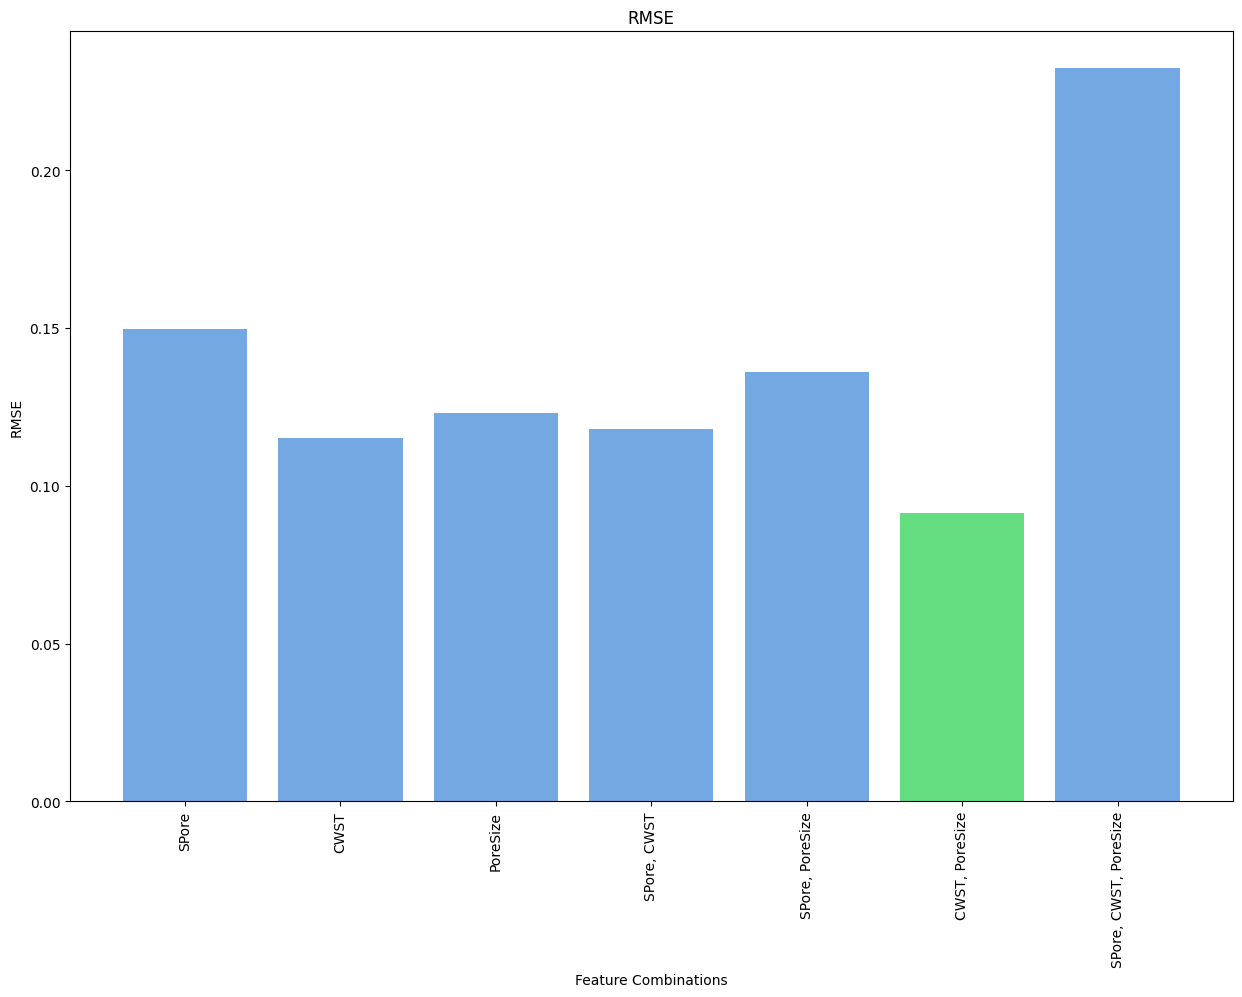

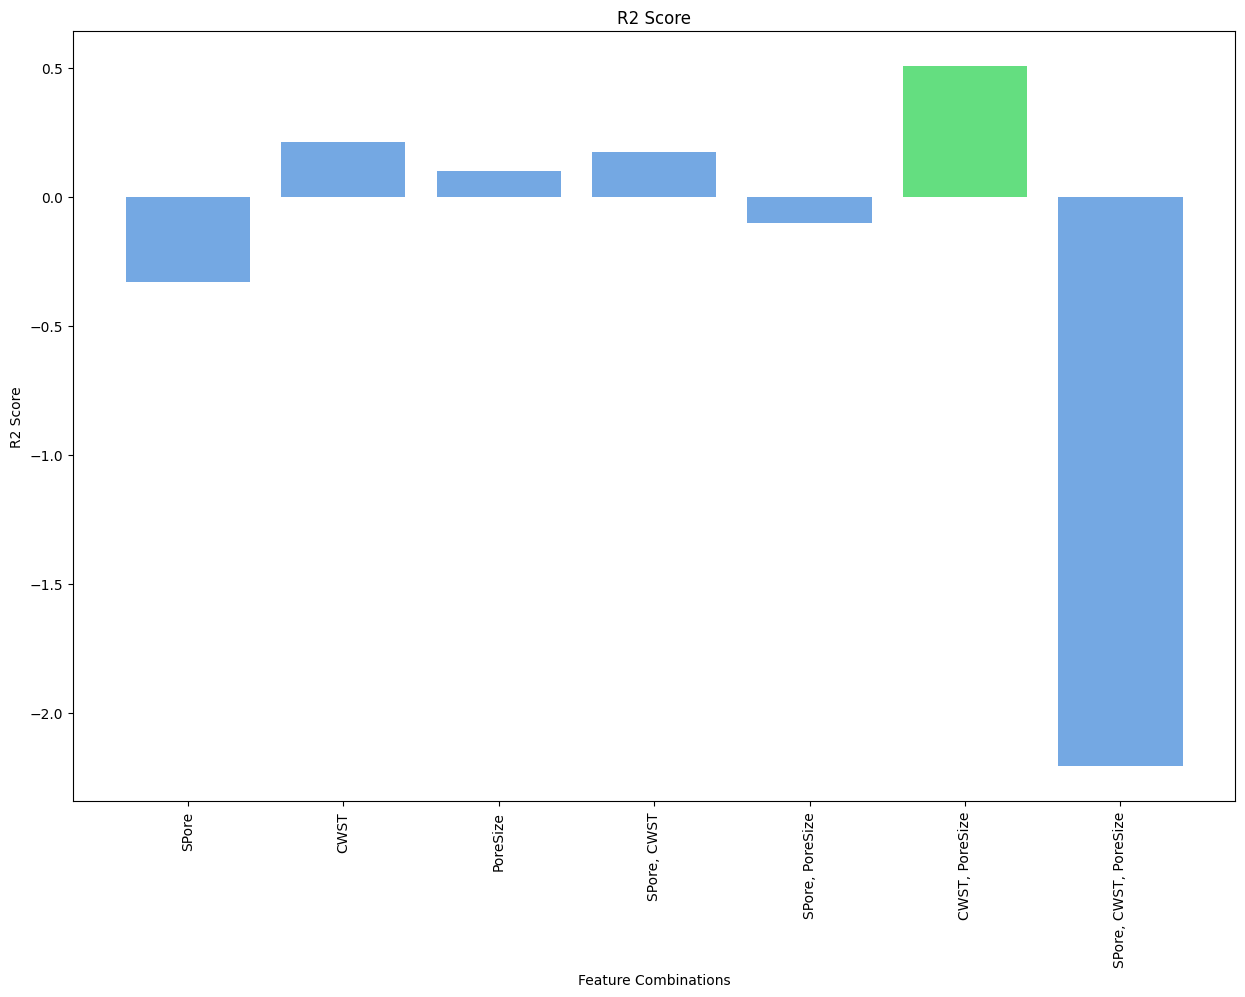

Best feature combination: ('CWST', 'PoreSize')
Best Root Mean squared error: 0.09126731524724464
Best R2 score: 0.5050621138275383


In [29]:
# MLPRegressor Leave One Out

import pandas as pd
import itertools
import numpy as np
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# Load CSV
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def preprocess_data(data):
    data = data.dropna()
    # Select features and target
    X = data.drop(["Model", "Flowrate(FR)","Valid-FR", "Valid-DR", "WBC(DR)"], axis=1)
    y = data["WBC(DR)"]
    
    # Save column
    column_names = X.columns
    
    # Scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert scaled data back to DataFrame
    X = pd.DataFrame(X, columns=column_names)

    return X, y, column_names


# Train
def train_model(X, y):
    loo = LeaveOneOut()
    models = []
    y_tests = []
    y_preds = []

    for train_index, test_index in tqdm(loo.split(X), total=len(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = MLPRegressor(hidden_layer_sizes=(10,10),activation="relu", solver='lbfgs', max_iter=10000, random_state=42)
        model.fit(X_train, y_train)
        models.append(model)

        y_pred = model.predict(X_test)
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    return models, np.array(y_tests), np.array(y_preds)

# Evaluate
def evaluate_model(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

def brute_force_search(data):
    X, y, column_names = preprocess_data(data)
    feature_combinations = []
    for i in range(1, len(column_names) + 1):
        feature_combinations.extend(list(itertools.combinations(column_names, i)))
    
    best_rmse = float('inf')
    best_r2 = 0
    best_combination = None
    best_models = None
    best_y_tests = None
    best_y_preds = None

    rmse_values = []
    r2_values = []
    combination_labels = []

    for combination in tqdm(feature_combinations, desc="Feature combinations"):
        X_comb = X[list(combination)]
        print('Doing ' + str(X_comb.columns.tolist()) + ' ...')
        models, y_tests, y_preds = train_model(X_comb, y)
        rmse, r2 = evaluate_model(y_tests, y_preds)
        rmse_values.append(rmse)
        r2_values.append(r2)
        combination_labels.append(', '.join(combination))

        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_combination = combination
            best_models = models
            best_y_tests = y_tests
            best_y_preds = y_preds

    visualize_results(combination_labels, rmse_values, r2_values)

    return best_combination, best_models, best_y_tests, best_y_preds

def visualize_results(combination_labels, rmse_values, r2_values):
    # Identify the best RMSE and R2
    best_rmse_index = rmse_values.index(min(rmse_values))
    best_r2_index = r2_values.index(max(r2_values))

    # Set colors for the bars
    rmse_colors = ['#74a8e3'] * len(rmse_values)
    rmse_colors[best_rmse_index] = '#64de80'
    r2_colors = ['#74a8e3'] * len(r2_values)
    r2_colors[best_r2_index] = '#64de80'

    # Plot RMSE values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, rmse_values, color=rmse_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.title('RMSE')
    plt.show()

    # Plot R2 values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, r2_values, color=r2_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('R2 Score')
    plt.xticks(rotation=90)
    plt.title('R2 Score')
    plt.show()

def main():
    file_path = file_name
    data = load_data(file_path)
    best_combination, best_models, best_y_tests, best_y_preds = brute_force_search(data)
    best_rmse, best_r2 = evaluate_model(best_y_tests, best_y_preds)
    
    print(f"Best feature combination: {best_combination}")
    print(f"Best Root Mean squared error: {best_rmse}")
    print(f"Best R2 score: {best_r2}")

if __name__ == "__main__":
    main()


In [46]:
# MLP Leave One Out and Plot

import pandas as pd
import itertools
import numpy as np
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import plotly.graph_objs as go
file_path = './20230317_DR.csv'

# Load CSV
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def preprocess_data(data):
    data = data.dropna()

    # Select features and target
    X = data.drop(["WBC(DR)", "Model"], axis=1)
    y = data["WBC(DR)"]

    # Save column names
    column_names = X.columns

    # Scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert scaled data back to DataFrame
    X = pd.DataFrame(X, columns=column_names)

    # Convert columns to string type
    X.columns = X.columns.astype(str)

    return X, y, column_names, scaler


# Train
def train_model(X, y):
    loo = LeaveOneOut()
    models = []
    y_tests = []
    y_preds = []

    for train_index, test_index in tqdm(loo.split(X), total=len(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = MLPRegressor(hidden_layer_sizes=(5,5), activation="relu", solver='lbfgs', max_iter=10000, random_state=42, alpha=0.001)
        model.fit(X_train, y_train)
        models.append(model)

        y_pred = model.predict(X_test)
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    return models, np.array(y_tests), np.array(y_preds)

# Evaluate
def evaluate_model(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2


def brute_force_search(data):
    X, y, column_names = preprocess_data(data)
    feature_combinations = []
    for i in range(1, len(column_names) + 1):
        feature_combinations.extend(list(itertools.combinations(column_names, i)))

    best_rmse = float('inf')
    best_r2 = 0
    best_combination = None
    best_models = None
    best_y_tests = None
    best_y_preds = None

    rmse_values = []
    r2_values = []
    combination_labels = []

    for combination in tqdm(feature_combinations, desc="Feature combinations"):
        X_comb = X[list(combination)]
        print('Doing ' + str(X_comb.columns.tolist()) + ' ...')
        models, y_tests, y_preds = train_model(X_comb, y)
        rmse, r2 = evaluate_model(y_tests, y_preds)
        rmse_values.append(rmse)
        r2_values.append(r2)
        combination_labels.append(', '.join(combination))

        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_combination = combination
            best_models = models
            best_y_tests = y_tests
            best_y_preds = y_preds

    visualize_results(combination_labels, rmse_values, r2_values)

    return best_combination, best_models, best_y_tests, best_y_preds

def visualize_surface(X, y, models, data, scaler):
    # Extract values for Model column
    model_names = data['Model']

    # Calculate the average prediction for each point in the grid
    xx, yy = np.meshgrid(
        np.linspace(X['PoreSize'].min(), X['PoreSize'].max(), 100),
        np.linspace(X['CWST'].min(), X['CWST'].max(), 100)
    )

    Z = np.zeros(xx.shape)
    for model in models:
        Z += model.predict(np.c_[yy.ravel(), xx.ravel()]).reshape(xx.shape)
    Z /= len(models)

    # Create a surface color matrix based on Z values
    surface_color = np.where(Z > 1, 1, 0)

    # Define custom colorscale
    custom_colorscale = [[0, 'rgb(30,144,255)'], [1, 'red']]

    # Create a 3D surface plot
    fig = go.Figure(
        go.Surface(x=xx, y=yy, z=Z, colorscale=custom_colorscale, surfacecolor=surface_color)
    )

    # Add scatter points with labels
    fig.add_trace(
        go.Scatter3d(
            x=X['CWST'], y=X['PoreSize'], z=y,
            mode='markers+text',
            text=model_names,
            textposition='top center',
            marker=dict(size=3, color='red')
        )
    )

    # Set layout
    fig.update_layout(
        title='3D Surface Plot',
        scene=dict(
            xaxis=dict(title='CWST',tickmode='array',tickvals=[-1.61791, -0.84436375, -0.0708175, 0.70272875, 1.476275],ticktext=[80,90,100,110,120]),
            yaxis=dict(title='PoreSize',tickmode='array',tickvals=[-1.609807,-1.1601536,-0.7105000,-0.2608464,0.1888072,0.6384608, 1.0881144, 1.537768],ticktext=[3.4,3.6,3.8,4.0,4.2,4.4,4.8,5.0]),
            zaxis=dict(title='WBC(DR)'),
            aspectmode='manual',
            aspectratio=dict(x=2, y=2, z=1)
        )
    )

    # Show the figure
    fig.show()

def main():
    file_path = '20230317_DR.csv'
    data = load_data(file_path)

    data = data[['PoreSize', 'CWST', 'WBC(DR)', 'Model']]

    X, y, column_names , scaler= preprocess_data(data)
    best_models, y_tests, y_preds = train_model(X, y)
    best_rmse, best_r2 = evaluate_model(y_tests, y_preds)

    import warnings
    warnings.filterwarnings("ignore")

    visualize_surface(X, y, best_models, data, scaler)

if __name__ == "__main__":
    main()

100%|██████████| 71/71 [00:05<00:00, 13.89it/s]


In [31]:
import pandas as pd
import itertools
import numpy as np
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# Load CSV
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def preprocess_data(data):
    data = data.dropna()
    
    # Select features and target
    X = data.drop(["WBC(DR)", "Model"], axis=1) 
    y = data["WBC(DR)"]
    
    # Save column names
    column_names = X.columns

    # Convert columns to string type
    X.columns = X.columns.astype(str)

    return X, y, column_names

# Train
def train_model(X, y):
    loo = LeaveOneOut()
    models = []
    y_tests = []
    y_preds = []

    for train_index, test_index in tqdm(loo.split(X), total=len(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = MLPRegressor(hidden_layer_sizes=(500,500), activation="relu", solver='adam', max_iter=10000, random_state=42)
        model.fit(X_train, y_train)
        models.append(model)

        y_pred = model.predict(X_test)
        y_tests.extend(y_test)
        y_preds.extend(y_pred)

    return models, np.array(y_tests), np.array(y_preds)

# Evaluate
def evaluate_model(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

def visualize_surface(X, y, models, data):
    # Extract values for Model column
    model_names = data['Model']

    # Define the range for xx and yy based on the current data
    xx_range = np.linspace(X['PoreSize'].min(), X['PoreSize'].max(), 100)
    yy_range = np.linspace(X['CWST'].min(), X['CWST'].max(), 100)

    # Calculate the average prediction for each point in the grid
    xx, yy = np.meshgrid(xx_range, yy_range)

    Z = np.zeros(xx.shape)
    for model in models:
        Z += model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    Z /= len(models)

    # Create 3D scatter plot
    scatter = go.Scatter3d(x=X['PoreSize'], y=X['CWST'], z=y,
                           mode='markers',
                           marker=dict(size=4, color='red', opacity=0.8),
                           text=model_names)

    # Create 3D surface plot
    surface = go.Surface(x=xx, y=yy, z=Z, colorscale='Viridis', opacity=0.8)

    # Combine scatter and surface plots
    data = [scatter, surface]

    # Set layout for the 3D plot
    layout = go.Layout(scene=dict(xaxis_title='PoreSize',
                                   yaxis_title='CWST',
                                   zaxis_title='WBC(DR)'))

    # Create and show the 3D plot
    fig = go.Figure(data=data, layout=layout)
    fig.show()


def find_satisfying_ranges(X, models, dr_threshold=1.0):
    pore_size_range = np.linspace(X['PoreSize'].min(), X['PoreSize'].max(), 100)
    cwst_range = np.linspace(X['CWST'].min(), X['CWST'].max(), 100)

    satisfying_pore_sizes = []
    satisfying_cwsts = []

    for pore_size in pore_size_range:
        for cwst in cwst_range:
            dr_sum = 0
            for model in models:
                dr_sum += model.predict(np.array([[pore_size, cwst]]))
            dr_avg = dr_sum / len(models)

            if dr_avg > dr_threshold:
                satisfying_pore_sizes.append(pore_size)
                satisfying_cwsts.append(cwst)

    return satisfying_pore_sizes, satisfying_cwsts

def main():
    file_path = file_name
    data = load_data(file_path)

    data = data[['PoreSize', 'CWST', 'WBC(DR)', 'Model']]

    X, y, _ = preprocess_data(data)
    best_models, y_tests, y_preds = train_model(X, y)
    best_rmse, best_r2 = evaluate_model(y_tests, y_preds)

    visualize_surface(X, y, best_models, data)

    satisfying_pore_sizes, satisfying_cwsts = find_satisfying_ranges(X, best_models)
    if satisfying_pore_sizes and satisfying_cwsts:
        print("PoreSize range with DR > 1.0: ", min(satisfying_pore_sizes), "-", max(satisfying_pore_sizes))
        print("CWST range with DR > 1.0: ", min(satisfying_cwsts), "-", max(satisfying_cwsts))
    else:
        print("No satisfying ranges found.")


if __name__ == "__main__":
    main()

100%|██████████| 71/71 [00:21<00:00,  3.32it/s]


KeyboardInterrupt: ignored

# Figure out the cost-efficient model

In [ ]:

path_Ori = './20230317.xlsx'
file_name = './20230317_FRxDR.csv'

# delete big title and save to csv
def xlsx_to_csv_pd():
    data_xls = pd.read_excel(path_Ori, index_col=0, header=0)
    data_xls.to_csv(file_name, encoding='utf-8', header=None)

xlsx_to_csv_pd() # 2 csv

# Complete the title
with open(file_name) as f:
    data=[row for row in csv.reader(f)]

with open(file_name, 'w', encoding='utf-8') as f:
    w = csv.writer(f)
    data[0][0]="Model"
    for row in data:
        w.writerow(row)  

# Drop 0 in Valid-FR
import pandas as pd

data = pd.read_csv(file_name)
filtered_data = data[(data['Valid-FR'] == 1) & (data['Valid-DR'] == 1)]
filtered_data.to_csv(file_name, index=False)

In [ ]:
data = pd.read_csv(file_name)
data.columns = data.columns.str.replace(' ', '') # delete space
data.to_csv(file_name, encoding='utf-8', index=None)
print(data.info())
print(data.describe())